In [88]:
%pip install vizdoom

Note: you may need to restart the kernel to use updated packages.


In [89]:
!cd github & git clone https://github.com/Farama-Foundation/ViZDoom.git

fatal: destination path 'ViZDoom' already exists and is not an empty directory.


In [90]:
# Import vizdoom for game env
from vizdoom import * 
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

In [91]:
# Setup game
game = DoomGame()
game.load_config('github/VizDoom/scenarios/deadly_corridor_s5.cfg')
game.init()

In [92]:
# This is the set of actions we can take in the environment
actions = np.identity(7, dtype=np.uint8)

In [93]:
actions

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [94]:
state = game.get_state()


In [95]:
state.game_variables

array([100.,   0.,   0.,  -1.])

In [96]:
health, damage_taken, hitcount, ammo = state.game_variables

In [97]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: -15.815673828125
reward: 7.0834503173828125
reward: 7.875152587890625
reward: 4.984954833984375
reward: 1.2668914794921875
reward: -6.9570465087890625
reward: -8.412628173828125
reward: -5.884063720703125
reward: -0.1043243408203125
reward: -0.03314208984375
reward: -0.0001068115234375
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 2.6519317626953125
reward: 9.734451293945312
reward: 12.659194946289062
reward: 12.485183715820312
reward: -2.1565093994140625
reward: -17.056671142578125
reward: -14.862930297851562
reward: -3.446441650390625
reward: 0.0
reward: 5.684295654296875
reward: 6.8190765380859375
reward: 1.168914794921875
reward: 2.96844482421875
reward: 3.5642852783203125
reward: 4.190765380859375
reward: -3.3385772705078125
reward: -5.4896240234375
reward: 0.403045654296875
reward: 8.01171875
reward: 2.7044677734375
reward: -1.1610260009765625
reward: -5.5225372314453125
reward: -6.213912963

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [98]:
game.close()

In [99]:
game.get_state().game_variables

array([28., 72.,  1., 50.])

In [100]:
%pip install gym


Note: you may need to restart the kernel to use updated packages.


In [101]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces 
from gym.spaces import Discrete, Box
# Import opencv 
import cv2

In [102]:
game.get_state().screen_buffer.shape

(3, 240, 320)

In [103]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False, config='github/VizDoom/scenarios/deadly_corridor_s1.cfg'): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config(config='github/VizDoom/scenarios/deadly_corridor_s1.cfg')
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(7)
        
        #Game variables = { HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO}
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4) 
        
        reward = 0
        
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            
            #Reward shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables

            #Calculate reward deltas
            damage_taken_delta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta =  ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200 + ammo_delta*5
            
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [104]:
env = VizDoomGym(render=True)

In [105]:
state = env.reset()

In [106]:
state.shape

(100, 160, 1)

In [107]:
np.moveaxis(state, 0, -1).shape

(160, 1, 100)

In [108]:
env.step(2)

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 0.0,
 False,
 {'info': 52.0})

In [109]:
env.close()

In [110]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [111]:
env_checker.check_env(env)


AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/

In [112]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [113]:
from matplotlib import pyplot as plt


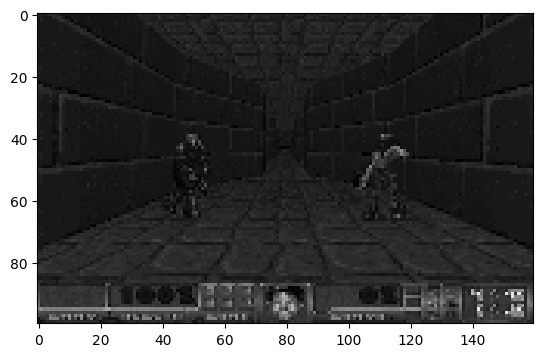

In [114]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))


In [116]:
env.observation_space.sample().shape

(100, 160, 1)

In [117]:
game.close()

In [122]:
Discrete(7).sample()

5

In [119]:
actions[Discrete(7).sample()]

array([0, 0, 1, 0, 0, 0, 0], dtype=uint8)

In [123]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [124]:
%pip install stable-baselines3[extra]

Note: you may need to restart the kernel to use updated packages.


In [125]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [126]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [127]:
CHECKPOINT_DIR = './train/train_deadly_corridor'
LOG_DIR = './logs/log_deadly_corridor'

In [128]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [129]:
# import ppo for training
from stable_baselines3 import PPO

In [130]:
# Non rendered environment
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_s1.cfg')

In [131]:
8192/64

128.0

In [132]:
#model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\arya6\.conda\envs\python3917\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [133]:
#model.learn(total_timesteps=40000, callback=callback)
model.learn(total_timesteps=400000, callback=callback)

Logging to ./logs/log_deadly_corridor\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 214      |
|    ep_rew_mean     | 110      |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 248      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 199          |
|    ep_rew_mean          | 145          |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 2            |
|    time_elapsed         | 500          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0033905501 |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained

In [ ]:
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s2.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

In [149]:
model.load('./train/train_deadly_corridor/best_model_260000.zip')

In [ ]:
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s3.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

In [ ]:
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s4.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

In [ ]:
env = VizDoomGym(config='github/ViZDoom/scenarios/deadly_corridor_s5.cfg')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

In [141]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [165]:
# Reload model from disc
model = PPO.load('./train/train_deadly_corridor/best_model_400000')

In [173]:
# Create rendered environment
env = VizDoomGym(render=True, config='github/VizDoom/scenarios/deadly_corridor_s2.cfg')

In [ ]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)

In [159]:
mean_reward

2762.1888427734375

In [169]:
model.predict(obs)

(array(3, dtype=int64), None)

In [171]:
for episode in range(20): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.02)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

ViZDoomIsNotRunningException: Controlled ViZDoom instance is not running or not ready.